# The Askeladden Algorithm <a class="tocSkip">

## W207 | Applied Machine Learning | Spring 2019<a class="tocSkip">

### Team Troll Trappers: Laura Pintos, Ramiro Cadavid, and Anna Jacobson<a class="tocSkip">

## Introduction

In February 2019, as part of special counsel Robert Mueller’s investigation of the Russian government's efforts to interfere in the 2016 presidential election, the United States Department of Justice charged 13 Russian nationals with illegally meddling in American political processes. The defendants worked for a well-funded “troll factory” called the Internet Research Agency (IRA), which reportedly had 400 employees, or “trolls”,  working 12-hour shifts from a nondescript business center in St. Petersburg. The IRA ran a sophisticated, coordinated campaign to spread disinformation and sow discord into American politics via social media, often Twitter. 

Twitter has identified and suspended thousands of these malicious accounts, deleting millions of the trolls’ tweets from public view on the platform. While other news outlets have published samples, it has been difficult to understand the full scale and scope of the IRA’s efforts, as well as the details of its strategy and tactics. According to Alina Polyakova, a foreign policy fellow at the Brookings Institution, “Wiping the content doesn’t wipe out the damage caused, and it prevents us from learning about how to be better prepared for such attacks in the future.” To address this problem, and “in line with our principles of transparency and to improve public understanding of alleged foreign influence campaigns,” Twitter has now made publicly available archives of Tweets and media that it believes resulted from potentially state-backed information operations.

More than 20% of the English-language troll tweets came from accounts with user names that mimicked those of legitimate news outlets. The purpose of this project is to try to predict "fake news" troll tweets.

In [165]:
# This tells matplotlib not to try opening a new window for 
# each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import string
import csv
import datetime
import pandas_ml as pdml
import seaborn as sns

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_mldata
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.naive_bayes import GaussianNB
from sklearn import preprocessing
from sklearn.model_selection import train_test_split


# SK-learn libraries for evaluation.
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

from pandas_ml import ConfusionMatrix

from pprint import pprint

from textblob import TextBlob

from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from time import time

from pylab import *

from sklearn.ensemble import VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import Perceptron
from sklearn.neighbors import NearestCentroid
from sklearn.feature_selection import SelectFromModel

In [ ]:
seed = 2019

## The Data

### Data Sources

#### Troll Tweets

Twitter has published a collection of datasets includes all public, undeleted tweets and media (e.g., images and videos) for 3,613 accounts that Twitter believes are connected to the Russian state-backed information operation Internet Research Agency (IRA). Tweets deleted by these users prior to their suspension (which are not included in these datasets) comprise less than 1% of their overall activity. The data consists of the full archive of information disclosed about the IRA. We decided to focus on the tweets dataset, which includes 8,768,633 unique tweets from May 2009 to June 2018. After filtering for English language tweets only, there are just under 3 million unique tweets in the dataset (2,997,181). These tweets come from 3,077 unique user accounts.

Most of the troll activity took place between 2014 and 2017, so we used this timeframe to define our period of interest. In order to segregate the "fake news" trolls, we filtered for user screen names containing the words 'Daily', 'New', 'Today', and 'Online'. This yielded 670,909 unique tweets from 33 unique user accounts with screen names such as TodayNYCity (58,630 tweets), ChicagoDailyNew    (53,071 tweets), and KansasDailyNews (51,648 tweets). We randomly sampled this set of data to get the same number of tweets as our real news tweet dataset (see below).

#### Real News Tweets

Harvard Dataverse has published a dataset containing the tweet IDs of 39,695,156 tweets collected from the Twitter accounts of approximately 4,500 news outlets (i.e., accounts of media organizations intended to disseminate news). The media organizations include everything from local U.S. newspapers to foreign television stations. They were collected between August 4, 2016 and July 20, 2018 from the Twitter API. 

Twitter's Developer Policy (which you agree to when you get keys for the Twitter API) places limits on the sharing of datasets. If you are sharing datasets of tweets, you can only publicly share the ids of the tweets, not the tweets themselves. Thus, this dataset, only contained the tweets ids. Based on the tweet ID, we retrieved the complete tweet from the Twitter API. We selected a variety of news outlets, including Politico, Fox News, CNN, The Economist, and MSNBC. In total, we have included 102,011 unique tweets from 50 unique user accounts.

#### Combined News Tweets

For this analysis, we combined the troll tweets and the real news tweets, for a combined dataset of 204,022 tweets. We included the text of each tweet and its category ('real' or 'troll'). No other identifying information is included.

### Data Preparation

In [78]:
# Load data.
df = pd.read_csv("news_tweets_big.csv")

In [79]:
# Delete extraneous index column.
del df['Unnamed: 0']

In [80]:
df.category.value_counts()

real     102011
troll    102011
Name: category, dtype: int64

In [81]:
df[df.category == 'troll'].head()

,tweet_text,category
0,"Louisville signee Donovan Mitchell's shoot 3, ...",troll
1,"Man, 45, stabs cousin in buttocks during fight...",troll
2,City Club forum for Ohio Supreme Court candida...,troll
3,Ocean Springs wide receiver Austin Williams ge...,troll
4,180 Duarte occupants must evacuate homes in fa...,troll


In [82]:
df[df.category == 'real'].head()

,tweet_text,category
102011,KT McFarland and Donald McGahn will join Trump...,real
102012,"Donald Trump picks Betsy DeVos, a top Republic...",real
102013,First lady Michelle Obama welcomes the White H...,real
102014,Constitutional law professor explains how Elec...,real
102015,The Trans-Pacific Partnership deal's death hur...,real


In [83]:
# Factorize the categories.
d = {'real':0, 'troll':1}
df['category'] = df['category'].map(d)
df.category.value_counts()

1    102011
0    102011
Name: category, dtype: int64

In [84]:
# Check that troll = 1 (and therefore, real = 0).
df[df.category == 1].head()

,tweet_text,category
0,"Louisville signee Donovan Mitchell's shoot 3, ...",1
1,"Man, 45, stabs cousin in buttocks during fight...",1
2,City Club forum for Ohio Supreme Court candida...,1
3,Ocean Springs wide receiver Austin Williams ge...,1
4,180 Duarte occupants must evacuate homes in fa...,1


In [85]:
my_df = pd.DataFrame(df,columns=['tweet_text'])
my_df['target'] = df.category
my_df.head()

,tweet_text,target
0,"Louisville signee Donovan Mitchell's shoot 3, ...",1
1,"Man, 45, stabs cousin in buttocks during fight...",1
2,City Club forum for Ohio Supreme Court candida...,1
3,Ocean Springs wide receiver Austin Williams ge...,1
4,180 Duarte occupants must evacuate homes in fa...,1


### Initial Data Exploration

In [86]:
my_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204022 entries, 0 to 204021
Data columns (total 2 columns):
tweet_text    204022 non-null object
target        204022 non-null int64
dtypes: int64(1), object(1)
memory usage: 3.1+ MB


In [18]:
'''
Generates a wordcloud for the selected target.
'''

def wordcloud(target):

    '''
    Args:
        target (int): selected target for which to generate wordcloud
    ''' 
        
    tweets = my_df[my_df.target == target]
    string = []
    for t in tweets.tweet_text:
        string.append(t)
    string = pd.Series(string).str.cat(sep=' ')
    from wordcloud import WordCloud

    wordcloud = WordCloud(width=1600, height=1200,
                          max_font_size=300).generate(string)
    plt.figure(figsize=(12,10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title('Wordcloud for Category %i'%target, fontsize = 12)
    plt.axis("off")
    plt.show()

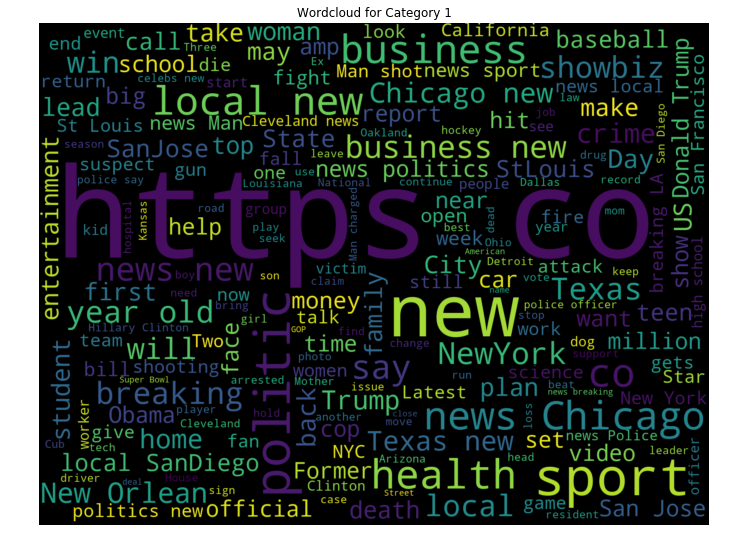

In [20]:
wordcloud(1)

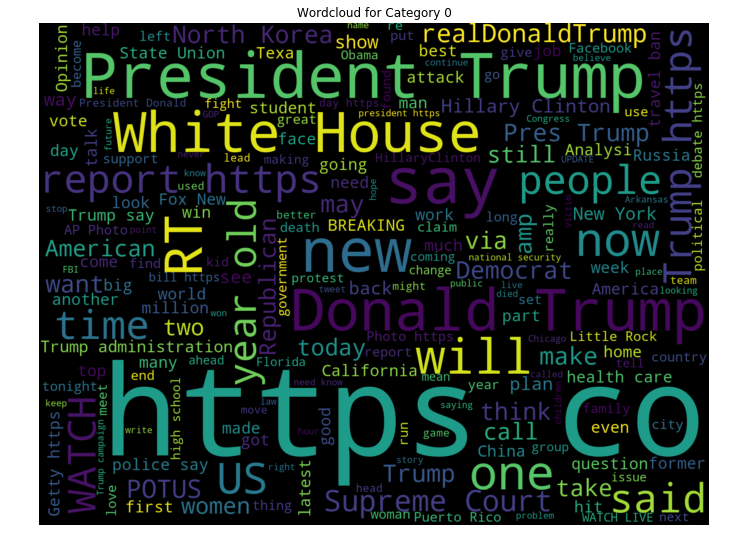

In [19]:
wordcloud(0)

### Initial Feature Extraction Exploration

In [21]:
cvec = CountVectorizer()
cvec.fit(my_df.tweet_text)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [22]:
len(cvec.get_feature_names())

254604

In [23]:
real_doc_matrix = cvec.transform(my_df[my_df.target == 0].tweet_text)
troll_doc_matrix = cvec.transform(my_df[my_df.target == 1].tweet_text)

real_tf = np.sum(real_doc_matrix,axis=0)
troll_tf = np.sum(troll_doc_matrix,axis=0)

real = np.squeeze(np.asarray(real_tf))
troll = np.squeeze(np.asarray(troll_tf))

term_freq_df = pd.DataFrame([real,troll],
                            columns=cvec.get_feature_names()).transpose()

In [24]:
term_freq_df.head()

,0,1
00,21,4
000,934,639
00003,5,0
000ft,3,0
000km,1,0


In [25]:
term_freq_df.columns = ['real', 'troll']
term_freq_df['total'] = term_freq_df['real'] + term_freq_df['troll']
term_freq_df.sort_values(by='total', ascending=False).iloc[:10]

,real,troll,total
co,128958,64588,193546
https,129791,61159,190950
the,51985,11408,63393
to,38453,24600,63053
in,28157,28709,56866
of,28700,14825,43525
news,1996,29170,31166
for,15786,13969,29755
on,16146,10126,26272
trump,21487,3264,24751


In [29]:
'''
Plots the top 50 tokens for the selected category.
'''

def top_tokens(category):
    
    '''
    args:
        category (str): specified category name
    '''
    
    y_pos = np.arange(50)
    plt.figure(figsize=(12,6))
    plt.bar(y_pos, term_freq_df.sort_values(by=category, ascending=False)[category][:50], 
            align='center', alpha=0.5)
    plt.xticks(y_pos, term_freq_df.sort_values(by=category, ascending=False)[category][:50].index,rotation='vertical')
    plt.ylabel('Frequency')
    plt.xlabel('Top 50 %s Tokens'%category)
    plt.title('Top 50 Tokens in %s Tweets'%category, fontsize=14)

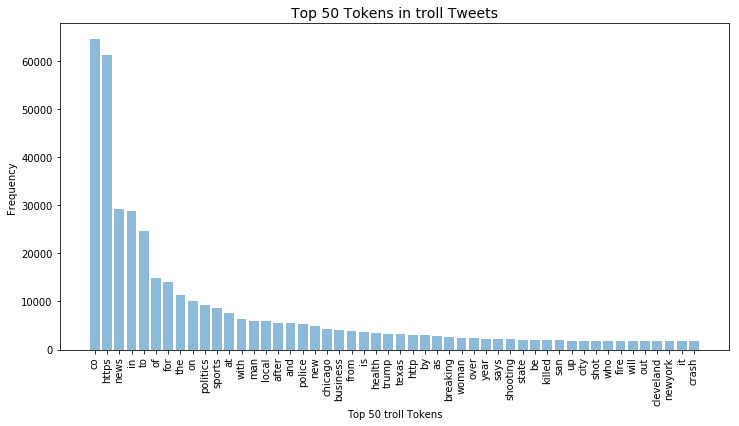

In [30]:
top_tokens('troll')

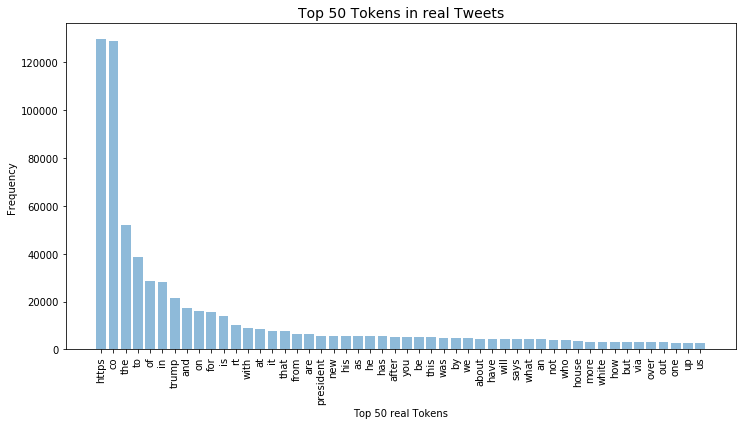

In [31]:
top_tokens('real')

Text(0.5, 1.0, 'Real News Frequency vs. Troll News Frequency')

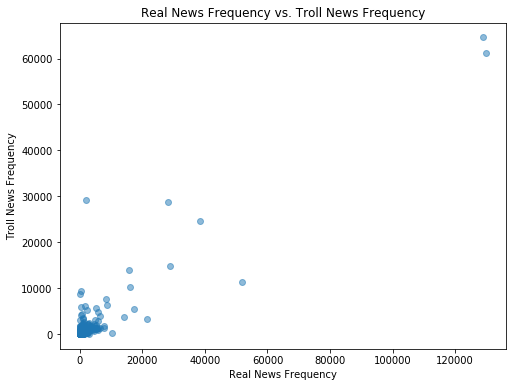

In [88]:
plt.figure(figsize=(8,6))
ax = sns.regplot(x="real", y="troll",fit_reg=False, 
                 scatter_kws={'alpha':0.5},data=term_freq_df)
plt.ylabel('Troll News Frequency')
plt.xlabel('Real News Frequency')
plt.title('Real News Frequency vs. Troll News Frequency')

### Data Split

In [89]:
x = my_df.tweet_text
y = my_df.target

x_train, x_dev_and_test, y_train, y_dev_and_test = train_test_split(x, y, test_size=0.4, random_state=seed)
x_dev, x_test, y_dev, y_test = train_test_split(x_dev_and_test, y_dev_and_test, test_size=0.5, random_state=seed)
targets = ['real','troll']

print('training data shape:', x_train.shape)
print('development data shape:', x_dev.shape)
print('test data shape:', x_test.shape)
print('labels names:', targets)

training data shape: (122413,)
development data shape: (40804,)
test data shape: (40805,)
labels names: ['real', 'troll']


## Initial Modeling

### Models 1-2: CountVectorizer KNN & Naive Bayes

In [37]:
'''
Instantiates the vectorizer and fits the data.
'''

# Instantiate the vectorizer.
vectorizer = CountVectorizer()

# Fit and transform the training data into a document-term matrix.
train_dtm = vectorizer.fit_transform(x_train)

# Transform the development data (using fitted vocabulary) into a document-term matrix.
dev_dtm = vectorizer.transform(x_dev)

#### Model 1: K-Nearest Neighbors

In [ ]:
'''
Fits a KNN Classifier, reports the F1 score, and finds the optimal value of K.
'''

def knn_class(k_values):
    
    '''
    Args:
        k_values (list): list of K values to try
        
    Returns:
        int, K value
        float, weighted F1 score
    '''

    for i in k_values:

        # Create a KNN Classifier and train it using the training set.
        knn = KNeighborsClassifier(n_neighbors=i)  
        knn.fit(train_dtm, y_train)

        # Output predictions.
        y_pred_P3a = knn.predict(dev_dtm)

        # Calculate and print accuracy.
        score = metrics.f1_score(y_dev, y_pred_P3a, average='weighted')
        print(f'''K: {i}   F1 Score: {score:.4f}''')

k_values = range(1,5)
knn_class(k_values)

#### Model 2: Bernoulli Naive Bayes

In [133]:
'''
Fits a Bernoulli Naive Bayes model and find the optimal value for alpha.
'''

def bnb_class(alphas):

    '''
    Args:
        alphas (list): list of alpha values to try
        
    Returns:
        float, best alpha in CV
        float, accuracy score for that alpha
    '''
        
    # Create a Bernoulli Naive Bayes Classifier 
    # and train it using the training set.
    bnb = BernoulliNB().fit(train_dtm, y_train)

    # Output predictions.
    y_pred_P3b = bnb.predict(dev_dtm)
   
    # Implement GridSearchCV.
    gscv = GridSearchCV(BernoulliNB(), alphas, cv=3, scoring='accuracy')
    
    # Fit model.
    gscv.fit(train_dtm, y_train)
    
    # Print results.
    print('Best alpha: %0.4f' % gscv.best_params_['alpha'])
    score = metrics.f1_score(y_dev, gscv.best_estimator_.predict(dev_dtm), 
                     average='weighted')
    print('Accuracy: %0.4f' % score)

alphas = {'alpha': [1.0e-10, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0]}
bnb_class(alphas)

Best alpha: 0.1000
Accuracy: 0.9068


#### Model 3: Intentionally Omitted

### Models 4-6: CountVectorizer Logistic Regression

In [145]:
# Instantiates the vectorizer and defines parameters.

cvec = CountVectorizer()
lr = LogisticRegression()
n_features = np.arange(25000, 200001, 25000)

In [124]:
def nfeature_accuracy_checker(vectorizer=cvec, n_features=n_features, 
                              stop_words=None, ngram_range=(1, 1), 
                              classifier=lr):
    result = []
    print(classifier)
    print("\n")
    
    for n in n_features:
        vectorizer.set_params(stop_words=stop_words, max_features=n, 
                              ngram_range=ngram_range)
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', classifier)
        ])
        print("Validation result for {} features".format(n))
        nfeature_accuracy,tt_time = accuracy_summary(checker_pipeline, 
                                                     x_train, y_train, 
                                                     x_dev, y_dev)
        result.append((n,nfeature_accuracy,tt_time))
    
    return result

In [125]:
from time import time

def accuracy_summary(pipeline, x_train, y_train, x_test, y_test):
    
    if len(x_test[y_test == 0]) / (len(x_test)*1.) > 0.5:
        null_accuracy = len(x_test[y_test == 0]) / (len(x_test)*1.)
    else:
        null_accuracy = 1. - (len(x_test[y_test == 0]) / (len(x_test)*1.))
    
    t0 = time()
    
    sentiment_fit = pipeline.fit(x_train, y_train)
    y_pred = sentiment_fit.predict(x_test)
    train_test_time = time() - t0
    accuracy = accuracy_score(y_test, y_pred)
    
    print("null accuracy: {0:.2f}%".format(null_accuracy*100))
    print("accuracy score: {0:.2f}%".format(accuracy*100))
    
    if accuracy > null_accuracy:
        print("model is {0:.2f}% more accurate than null accuracy".format((accuracy-null_accuracy)*100))
    elif accuracy == null_accuracy:
        print("model has the same accuracy with the null accuracy")
    else:
        print("model is {0:.2f}% less accurate than null accuracy".format((null_accuracy-accuracy)*100))
    
    print("train and test time: {0:.2f}s".format(train_test_time))
    print("-"*80)
    
    return accuracy, train_test_time      

#### Model 4: Unigram CV

In [126]:
# Runs the nfeature_accuracy_checker function.

print("UNIGRAM\n")
feature_result_ug = nfeature_accuracy_checker()

UNIGRAM

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)


Validation result for 25000 features


/Applications/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


null accuracy: 50.10%
accuracy score: 90.54%
model is 40.44% more accurate than null accuracy
train and test time: 7.27s
--------------------------------------------------------------------------------
Validation result for 50000 features
null accuracy: 50.10%
accuracy score: 90.64%
model is 40.54% more accurate than null accuracy
train and test time: 7.49s
--------------------------------------------------------------------------------
Validation result for 75000 features
null accuracy: 50.10%
accuracy score: 90.57%
model is 40.47% more accurate than null accuracy
train and test time: 8.73s
--------------------------------------------------------------------------------
Validation result for 100000 features
null accuracy: 50.10%
accuracy score: 90.61%
model is 40.51% more accurate than null accuracy
train and test time: 10.22s
--------------------------------------------------------------------------------
Validation result for 125000 features
null accuracy: 50.10%
accuracy score: 90.

#### Model 5: Bigram CV

In [49]:
print("BIGRAM\n")
feature_result_bg = nfeature_accuracy_checker(ngram_range=(1, 2))

RESULT FOR BIGRAM WITH STOP WORDS

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)


Validation result for 25000 features


/Applications/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


null accuracy: 50.10%
accuracy score: 90.83%
model is 40.73% more accurate than null accuracy
train and test time: 15.48s
--------------------------------------------------------------------------------
Validation result for 50000 features
null accuracy: 50.10%
accuracy score: 91.30%
model is 41.20% more accurate than null accuracy
train and test time: 16.76s
--------------------------------------------------------------------------------
Validation result for 75000 features
null accuracy: 50.10%
accuracy score: 91.40%
model is 41.29% more accurate than null accuracy
train and test time: 16.57s
--------------------------------------------------------------------------------
Validation result for 100000 features
null accuracy: 50.10%
accuracy score: 91.50%
model is 41.40% more accurate than null accuracy
train and test time: 18.37s
--------------------------------------------------------------------------------
Validation result for 125000 features
null accuracy: 50.10%
accuracy score: 

#### Model 6: Trigram CV

In [50]:
print("TRIGRAM\n")
feature_result_tg = nfeature_accuracy_checker(ngram_range=(1, 3))

TRIGRAM WITH STOP WORDS

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)


Validation result for 25000 features


/Applications/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


null accuracy: 50.10%
accuracy score: 90.78%
model is 40.68% more accurate than null accuracy
train and test time: 27.91s
--------------------------------------------------------------------------------
Validation result for 50000 features
null accuracy: 50.10%
accuracy score: 91.19%
model is 41.09% more accurate than null accuracy
train and test time: 27.46s
--------------------------------------------------------------------------------
Validation result for 75000 features
null accuracy: 50.10%
accuracy score: 91.35%
model is 41.25% more accurate than null accuracy
train and test time: 28.62s
--------------------------------------------------------------------------------
Validation result for 100000 features
null accuracy: 50.10%
accuracy score: 91.45%
model is 41.35% more accurate than null accuracy
train and test time: 29.71s
--------------------------------------------------------------------------------
Validation result for 125000 features
null accuracy: 50.10%
accuracy score: 

#### Comparison

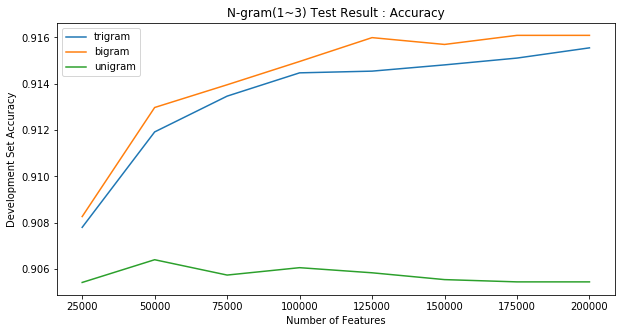

In [52]:
nfeatures_plot_tg = pd.DataFrame(feature_result_tg,
                                 columns=['nfeatures',
                                          'dev_accuracy',
                                          'train_test_time'])
nfeatures_plot_bg = pd.DataFrame(feature_result_bg,
                                 columns=['nfeatures',
                                          'dev_accuracy',
                                          'train_test_time'])
nfeatures_plot_ug = pd.DataFrame(feature_result_ug,
                                 columns=['nfeatures', 
                                          'dev_accuracy',
                                          'train_test_time'])

plt.figure(figsize=(10,5))

# Plot trigram model.
plt.plot(nfeatures_plot_tg.nfeatures, nfeatures_plot_tg.dev_accuracy,
         label='trigram')

# Plot bigram model.
plt.plot(nfeatures_plot_bg.nfeatures, nfeatures_plot_bg.dev_accuracy,
         label='bigram')

# Plot unigram model.
plt.plot(nfeatures_plot_ug.nfeatures, nfeatures_plot_ug.dev_accuracy,
         label='unigram')

plt.title("N-gram(1~3) Test Result : Accuracy")
plt.xlabel("Number of Features")
plt.ylabel("Development Set Accuracy")
plt.legend()

The bigram model shows the best accuracy. The trigram model has a similar curve with slightly less accuracy. The unigram model clearly performs the worst of the three.

### Models 7-9: TFIDFVectorizer Logistic Regression

In [128]:
# Instantiates the vectorizer.
tvec = TfidfVectorizer()

#### Model 7: Unigram TFIDF

In [ ]:
print("UNIGRAM\n")
feature_result_ugt = nfeature_accuracy_checker(vectorizer=tvec)

#### Model 8: Bigram TFIDF

In [ ]:
print("BIGRAM\n")
feature_result_bgt = nfeature_accuracy_checker(vectorizer=tvec,
                                               ngram_range=(1, 2))

#### Model 9: Trigram TFIDF

In [ ]:
print("TRIGRAM\n")
feature_result_tgt = nfeature_accuracy_checker(vectorizer=tvec,
                                               ngram_range=(1, 3))

#### Comparison

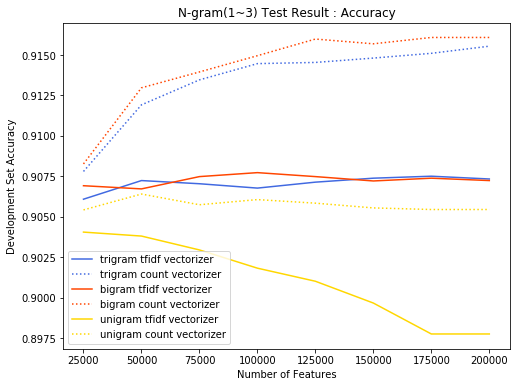

In [54]:
nfeatures_plot_tgt = pd.DataFrame(feature_result_tgt,
                                  columns=['nfeatures','dev_accuracy',
                                           'train_test_time'])
nfeatures_plot_bgt = pd.DataFrame(feature_result_bgt,
                                  columns=['nfeatures','dev_accuracy',
                                           'train_test_time'])
nfeatures_plot_ugt = pd.DataFrame(feature_result_ugt,
                                  columns=['nfeatures','dev_accuracy',
                                           'train_test_time'])

plt.figure(figsize=(8,6))

# Plot trigram models.
plt.plot(nfeatures_plot_tgt.nfeatures, 
         nfeatures_plot_tgt.dev_accuracy,
         label='trigram tfidf vectorizer', 
         color='royalblue')
plt.plot(nfeatures_plot_tg.nfeatures, 
         nfeatures_plot_tg.dev_accuracy,
         label='trigram count vectorizer',
         linestyle=':', 
         color='royalblue')

# Plot bigram models.
plt.plot(nfeatures_plot_bgt.nfeatures, 
         nfeatures_plot_bgt.dev_accuracy,
         label='bigram tfidf vectorizer', 
         color='orangered')
plt.plot(nfeatures_plot_bg.nfeatures, 
         nfeatures_plot_bg.dev_accuracy,
         label='bigram count vectorizer', 
         linestyle=':',
         color='orangered')

# Plot unigram models.
plt.plot(nfeatures_plot_ugt.nfeatures, 
         nfeatures_plot_ugt.dev_accuracy, 
         label='unigram tfidf vectorizer',
         color='gold')
plt.plot(nfeatures_plot_ug.nfeatures, 
         nfeatures_plot_ug.dev_accuracy, 
         label='unigram count vectorizer', 
         linestyle=':',
         color='gold')

plt.title("N-gram(1~3) Test Result : Accuracy")
plt.xlabel("Number of Features")
plt.ylabel("Development Set Accuracy")
plt.legend()

As with CountVectorizer, the TFIDF bigram and trigram models perform much better than the TFIDF unigram model. However, the CountVectorizer models are more accurate than the TFIDF models, particularly as the number of features increases.

### Model 10: Ensemble

In [168]:
from time import time

names = ["Logistic Regression", "Linear SVC", 
         "LinearSVC with L1-based feature selection","Multinomial NB", 
         "Bernoulli NB", "Ridge Classifier", "AdaBoost", "Perceptron",
         "Passive-Aggresive", "Nearest Centroid", "Random Forest"]
classifiers = [
    LogisticRegression(),
    LinearSVC(),
    Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False))),
  ('classification', LinearSVC(penalty="l2"))]),
    MultinomialNB(),
    BernoulliNB(),
    RidgeClassifier(),
    AdaBoostClassifier(),
    Perceptron(),
    PassiveAggressiveClassifier(),
    NearestCentroid(),
    RandomForestClassifier(),
    ]
zipped_clf = zip(names,classifiers)

cvec = CountVectorizer()

def classifier_comparator(vectorizer=cvec, n_features=10000, 
                          stop_words=None, ngram_range=(1,1), classifier=zipped_clf):
    result = []
    vectorizer.set_params(stop_words=stop_words, max_features=n_features, 
                          ngram_range=ngram_range)
    for n,c in classifier:
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', c)
        ])
        print("Validation result for {}".format(n))
        print(c)
        clf_accuracy,tt_time = accuracy_summary(checker_pipeline, 
                                                x_train, y_train, 
                                                x_dev, y_dev)
        result.append((n,clf_accuracy,tt_time))
    return result

bigram_result = classifier_comparator(n_features=100000,ngram_range=(1,2))

Validation result for Logistic Regression
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)


/Applications/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


null accuracy: 50.10%
accuracy score: 91.50%
model is 41.40% more accurate than null accuracy
train and test time: 18.49s
--------------------------------------------------------------------------------
Validation result for Linear SVC
LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
null accuracy: 50.10%
accuracy score: 90.60%
model is 40.50% more accurate than null accuracy
train and test time: 25.45s
--------------------------------------------------------------------------------
Validation result for LinearSVC with L1-based feature selection
Pipeline(memory=None,
     steps=[('feature_selection', SelectFromModel(estimator=LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l1', random_state=None, tol=0.0001,


/Applications/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in Perceptron in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


null accuracy: 50.10%
accuracy score: 90.08%
model is 39.98% more accurate than null accuracy
train and test time: 14.27s
--------------------------------------------------------------------------------
Validation result for Passive-Aggresive
PassiveAggressiveClassifier(C=1.0, average=False, class_weight=None,
              early_stopping=False, fit_intercept=True, loss='hinge',
              max_iter=None, n_iter=None, n_iter_no_change=5, n_jobs=None,
              random_state=None, shuffle=True, tol=None,
              validation_fraction=0.1, verbose=0, warm_start=False)


/Applications/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in PassiveAggressiveClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


null accuracy: 50.10%
accuracy score: 90.09%
model is 39.99% more accurate than null accuracy
train and test time: 14.49s
--------------------------------------------------------------------------------
Validation result for Nearest Centroid
NearestCentroid(metric='euclidean', shrink_threshold=None)
null accuracy: 50.10%
accuracy score: 77.14%
model is 27.04% more accurate than null accuracy
train and test time: 14.46s
--------------------------------------------------------------------------------
Validation result for Random Forect
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


null accuracy: 50.10%
accuracy score: 91.23%
model is 41.13% more accurate than null accuracy
train and test time: 96.34s
--------------------------------------------------------------------------------


In [208]:
'''
Creates an ensemble model using the algorithms above with over 90% accuracy.
'''

clf1 = LogisticRegression()
clf2 = LinearSVC()
clf3 = BernoulliNB()
clf4 = Perceptron()
clf5 = PassiveAggressiveClassifier()
clf6 = RandomForestClassifier()

eclf = VotingClassifier(estimators=[('lr', clf1), ('svc', clf2), 
                                    ('bnb', clf3), ('rcs', clf4), 
                                    ('pac', clf5), ('rfc', clf6)], voting='hard')

checker_pipeline = Pipeline([
            ('vectorizer', CountVectorizer(max_features=200000,
                                           ngram_range=(1, 2))),
            ('classifier', eclf)
        ])
print("Ensemble Model'))
print(clf)
clf_accuracy,tt_time = accuracy_summary(checker_pipeline, 
                                        x_train, y_train, 
                                        x_dev, y_dev)

Validation result for Ensemble
<function clf at 0x11914fa60>


/Applications/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in Perceptron in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in PassiveAggressiveClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.

null accuracy: 50.10%
accuracy score: 92.29%
model is 42.19% more accurate than null accuracy
train and test time: 180.69s
--------------------------------------------------------------------------------


The ensemble model has slightly better accuracy than our previous best model, the bigram CountVectorizer logistic regression model (Model 5).

### Models 11-14: Doc2Vec

In [59]:
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from gensim.models.doc2vec import LabeledSentence
import multiprocessing
from sklearn import utils

In [144]:
def labelize_tweets_ug(tweets,label):
    result = []
    prefix = label
    for i, t in zip(tweets.index, tweets):
        result.append(LabeledSentence(t.split(), [prefix + '_%s' % i]))
    return result
  
all_x = pd.concat([x_train,x_dev,x_test])
all_x_w2v = labelize_tweets_ug(all_x, 'all')

/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).
  """


#### Model 11: DBOW (Distributed Bag Of Words)

In [61]:
cores = multiprocessing.cpu_count()
model_ug_dbow = Doc2Vec(dm=0, vector_size=100, negative=5, min_count=2, 
                        workers=cores, alpha=0.065, min_alpha=0.065)
model_ug_dbow.build_vocab([x for x in tqdm(all_x_w2v)])

for epoch in range(10):
    model_ug_dbow.train(utils.shuffle([x for x in tqdm(all_x_w2v)]), 
                        total_examples=len(all_x_w2v), epochs=1)
    model_ug_dbow.alpha -= 0.002
    model_ug_dbow.min_alpha = model_ug_dbow.alpha
    
def get_vectors(model, corpus, size):
    vecs = np.zeros((len(corpus), size))
    n = 0
    for i in corpus.index:
        prefix = 'all_' + str(i)
        vecs[n] = model.docvecs[prefix]
        n += 1
    return vecs
  
train_vecs_dbow = get_vectors(model_ug_dbow, x_train, 100)
dev_vecs_dbow = get_vectors(model_ug_dbow, x_dev, 100)

clf = LogisticRegression()
clf.fit(train_vecs_dbow, y_train)
clf.score(dev_vecs_dbow, y_dev)

100%|██████████| 204022/204022 [00:00<00:00, 2333845.95it/s]
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.8543770218606019

The DBOW model is not as accurate as the previous logistic regression models, nor the ensemble model (Model 10)

#### Model 12: DMC (Distributed Memory Concatenation)

In [62]:
cores = multiprocessing.cpu_count()
model_ug_dmc = Doc2Vec(dm=1, dm_concat=1, vector_size=100, window=2, 
                       negative=5, min_count=2, workers=cores, 
                       alpha=0.065, min_alpha=0.065)
model_ug_dmc.build_vocab([x for x in tqdm(all_x_w2v)])

for epoch in range(10):
    model_ug_dmc.train(utils.shuffle([x for x in tqdm(all_x_w2v)]), 
                       total_examples=len(all_x_w2v), epochs=1)
    model_ug_dmc.alpha -= 0.002
    model_ug_dmc.min_alpha = model_ug_dmc.alpha

train_vecs_dmc = get_vectors(model_ug_dmc, x_train, 100)
dev_vecs_dmc = get_vectors(model_ug_dmc, x_dev, 100)

clf = LogisticRegression()
clf.fit(train_vecs_dmc, y_train)
clf.score(dev_vecs_dmc, y_dev)

100%|██████████| 204022/204022 [00:00<00:00, 2428140.95it/s]
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.6046466032741888

At just over 60% accuracy, the DMC model performance is unimpressive. However, the model does seems to have learned the valid vector representation at the word level fairly well. Some examples:

In [63]:
model_ug_dmc.wv.most_similar('president')

[('president,', 0.6381537914276123),
 ('president:', 0.5877475142478943),
 ('president.', 0.5688449740409851),
 ('versa', 0.5567770004272461),
 ('#MedalOfHonor', 0.552739143371582),
 ('Policy,', 0.5525267124176025),
 ('president.…', 0.5409814119338989),
 ('gifts:', 0.5369707345962524),
 ('"simply', 0.5164239406585693),
 ('PSC', 0.5077798366546631)]

In [64]:
model_ug_dmc.wv.most_similar('shooting')

[('shootings', 0.6277099251747131),
 ('massacre', 0.6247107982635498),
 ('shooting,', 0.6156536340713501),
 ('shooting:', 0.5880472660064697),
 ('shootings?', 0.5760138034820557),
 ('shooting…', 0.5745621919631958),
 ('#shooting', 0.5699948072433472),
 ('Shooting', 0.5635703206062317),
 ('closing,', 0.5581514835357666),
 ('stabbing', 0.554500162601471)]

#### Model 13: DMM (Distributed Memory Mean)

In [66]:
cores = multiprocessing.cpu_count()
model_ug_dmm = Doc2Vec(dm=1, dm_mean=1, vector_size=100, window=4, negative=5, min_count=2, workers=cores, alpha=0.065, min_alpha=0.065)
model_ug_dmm.build_vocab([x for x in tqdm(all_x_w2v)])

for epoch in range(10):
    model_ug_dmm.train(utils.shuffle([x for x in tqdm(all_x_w2v)]), total_examples=len(all_x_w2v), epochs=1)
    model_ug_dmm.alpha -= 0.002
    model_ug_dmm.min_alpha = model_ug_dmm.alpha
    
train_vecs_dmm = get_vectors(model_ug_dmm, x_train, 100)
dev_vecs_dmm = get_vectors(model_ug_dmm, x_dev, 100)

clf = LogisticRegression()
clf.fit(train_vecs_dmm, y_train)
clf.score(dev_vecs_dmm, y_dev)

100%|██████████| 204022/204022 [00:00<00:00, 2127999.45it/s]
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.780021566513087

The DMM model far outperforms the DMC model. This is supported by examination of its learning at the word level, which also appears to be improved:

In [67]:
model_ug_dmm.wv.most_similar('president')

[('president,', 0.5659866333007812),
 ('presidency', 0.5394474267959595),
 ('president-elect', 0.5087478160858154),
 ('President', 0.5063180923461914),
 ('lawyer', 0.47945937514305115),
 ('mayor', 0.47773969173431396),
 ('Tillerson', 0.47137904167175293),
 ('pope', 0.47115984559059143),
 ('regime', 0.4705018103122711),
 ('versa', 0.4684845209121704)]

In [68]:
model_ug_dmc.wv.most_similar('shooting')

[('shootings', 0.6277099251747131),
 ('massacre', 0.6247107982635498),
 ('shooting,', 0.6156536340713501),
 ('shooting:', 0.5880472660064697),
 ('shootings?', 0.5760138034820557),
 ('shooting…', 0.5745621919631958),
 ('#shooting', 0.5699948072433472),
 ('Shooting', 0.5635703206062317),
 ('closing,', 0.5581514835357666),
 ('stabbing', 0.554500162601471)]

#### Model 14: Combined DBOW+DMM Model

In [72]:
def get_concat_vectors(model1, model2, corpus, size):
    vecs = np.zeros((len(corpus), size))
    n = 0
    for i in corpus.index:
        prefix = 'all_' + str(i)
        vecs[n] = np.append(model1.docvecs[prefix],model2.docvecs[prefix])
        n += 1
    return vecs

In [74]:
train_vecs_dbow_dmm = get_concat_vectors(model_ug_dbow,model_ug_dmm, x_train, 200)
dev_vecs_dbow_dmm = get_concat_vectors(model_ug_dbow,model_ug_dmm, x_dev, 200)

clf = LogisticRegression()
clf.fit(train_vecs_dbow_dmm, y_train)
clf.score(dev_vecs_dbow_dmm, y_dev)

/Applications/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.8690079403980002

Of the Doc2Vec models, the DBOW+DMM model is the most accurate. However, the CountVectorizer logistic regression models all perform better. 

## Model 5 Development

Given the high accuracy and parsimony of our intitial CountVectorizer bigram logistic regression model (Model 5), we selected this model for further development.

### Stop Word Removal

In [44]:
term_freq_df.sort_values(by='total', ascending=False).iloc[:10]

,real,troll,total
co,128958,64588,193546
https,129791,61159,190950
the,51985,11408,63393
to,38453,24600,63053
in,28157,28709,56866
of,28700,14825,43525
news,1996,29170,31166
for,15786,13969,29755
on,16146,10126,26272
trump,21487,3264,24751


In [131]:
my_stop_words = frozenset(list(term_freq_df.sort_values(by='total', 
                                                        ascending=False).iloc[:10].index))

In [127]:
print("BIGRAM WITHOUT STANDARD STOP WORDS\n")
feature_result_wosw = nfeature_accuracy_checker(stop_words='english', 
                                                ngram_range=(1, 2))

BIGRAM WITHOUT STANDARD STOP WORDS

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)


Validation result for 25000 features


/Applications/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


null accuracy: 50.10%
accuracy score: 90.04%
model is 39.93% more accurate than null accuracy
train and test time: 12.59s
--------------------------------------------------------------------------------
Validation result for 50000 features
null accuracy: 50.10%
accuracy score: 90.50%
model is 40.40% more accurate than null accuracy
train and test time: 12.83s
--------------------------------------------------------------------------------
Validation result for 75000 features
null accuracy: 50.10%
accuracy score: 90.61%
model is 40.51% more accurate than null accuracy
train and test time: 12.87s
--------------------------------------------------------------------------------
Validation result for 100000 features
null accuracy: 50.10%
accuracy score: 90.70%
model is 40.60% more accurate than null accuracy
train and test time: 13.60s
--------------------------------------------------------------------------------
Validation result for 125000 features
null accuracy: 50.10%
accuracy score: 

In [ ]:
print("BIGRAM WITHOUT CORPUS-SPECIFIC STOP WORDS (Top 10)\n")
feature_result_wocsw = nfeature_accuracy_checker(stop_words=my_stop_words, 
                                                 ngram_range=(1, 2))

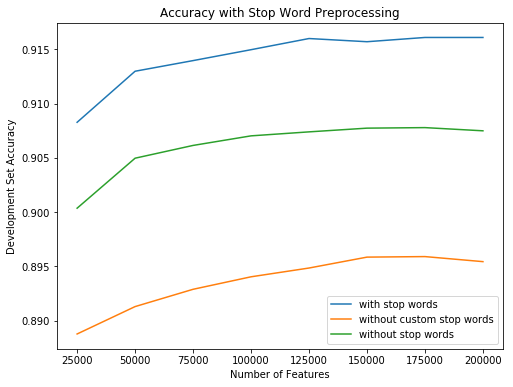

In [130]:
nfeatures_plot_bg = pd.DataFrame(feature_result_bg,
                                 columns=['nfeatures',
                                          'validation_accuracy',
                                          'train_test_time'])
nfeatures_plot_bg_wocsw = pd.DataFrame(feature_result_wocsw,
                                       columns=['nfeatures',
                                                'validation_accuracy',
                                                'train_test_time'])
nfeatures_plot_bg_wosw = pd.DataFrame(feature_result_wosw,
                                      columns=['nfeatures',
                                               'validation_accuracy',
                                               'train_test_time'])

plt.figure(figsize=(8,6))

plt.plot(nfeatures_plot_bg.nfeatures, 
         nfeatures_plot_bg.validation_accuracy, 
         label='with stop words')
plt.plot(nfeatures_plot_bg_wocsw.nfeatures, 
         nfeatures_plot_bg_wocsw.validation_accuracy,
         label='without custom stop words')
plt.plot(nfeatures_plot_bg_wosw.nfeatures, 
         nfeatures_plot_bg_wosw.validation_accuracy,
         label='without stop words')

plt.title("Accuracy with Stop Word Preprocessing")
plt.xlabel("Number of Features")
plt.ylabel("Development Set Accuracy")
plt.legend()

Accuracy is clearly best with the stop words preserved in the data.

### C Value Optimization

In [93]:
# Instantiates bigram CountVectorizer and transforms data.

bigram_vectorizer = CountVectorizer(ngram_range=(1, 2),
                                     token_pattern=r'\b\w+\b', min_df=1)
W_2 = bigram_vectorizer.fit_transform(x_train)
dev_dtm_2 = bigram_vectorizer.transform(x_dev)

In [136]:
def best_C(x, y):

    # C values to try
    Cs = [0.001, 0.01, 0.03, 0.05, 0.075, 0.1, 0.15, 0.3, 0.5, 0.7, 1, 2]
    
    tweets = LogisticRegressionCV(Cs=Cs, cv=5, penalty='l2', solver='saga',  
                                multi_class='multinomial', class_weight='balanced',
                                random_state=random_state, scoring='accuracy', tol=0.01,
                                refit=False).fit(x, y)
    
    print(f"The optimal C value found by LogisticRegressionCV based on accuracy is {tweets.C_[0]:.2f}.")

best_C(W_2, y_train)

The optimal C value found by LogisticRegressionCV based on accuracy is 1.80.


In [114]:
# Instantiate logistic regresion object with best C value.
tweets = LogisticRegression(penalty='l2', tol=0.01, C=1.80, solver='saga',
                            multi_class='multinomial', class_weight='balanced', 
                            random_state=random_state)

# Make predictions and report accuracy.
tweets.fit(W_2, y_train)
predicted_labels = tweets.predict(dev_dtm_2)
print(f"Accuracy Score: {accuracy_score(y_dev, predicted_labels)*100:.2f}\n")

accuracy score: 91.76



Adjusting the value of C from the default of 1 to 1.8 gives us an accuracy of 91.76%, a 0.15 percentage point improvement over Model 5 (91.61% accuracy).

### Confused Tweets

In [108]:
def most_confused_tweets(n_examples):

    d = {0 :'real', 1 : 'troll'}
    
    # estimate probabilities for dev data and R ratios
    probabilities = tweets.predict_proba(dev_dtm_2)
        
    R = [np.max(probabilities[idx,]) / probabilities[idx, label]\
                 for idx, label in zip(range(y_dev.shape[0]), y_dev)]
    
    # find the top n_examples where R is largest
    examples = max_idx(R, n_examples)
    
    # print the examples
    for example in examples:
        true_label = y_dev.values[example]
        print(
            f"Example {example}\n"
            f"True Label: {d[true_label]}\n"
            f"Predicted Label: {d[predicted_labels[example]]}\n" 
            f"R ratio: {R[example]:.2f}\n"
            f"Predicted Probability: {np.max(probabilities[example,])}\n"
            f"Estimated Probability of True label: {probabilities[example, true_label]}\n"
            f"{x_dev.values[example]}\n")

most_confused_tweets(10)

Example 39086
True Label: real
Predicted Label: troll
R ratio: 875532.69
Predicted Probability: 0.9999988578394936
Estimated Probability of True label: 1.1421605064341064e-06
"News is entertainment and entertainment is news" https://t.co/h0qOHVUQ8p https://t.co/uBXdO6aSTl

Example 22244
True Label: troll
Predicted Label: real
R ratio: 23401.60
Predicted Probability: 0.9999572697044724
Estimated Probability of True label: 4.2730295527516086e-05
RT @chicagotribune: The rally that wasn't and a night that will leave an indelible mark on the 2016 campaign https://t.co/TtMH8QuyNq https:…

Example 17598
True Label: troll
Predicted Label: real
R ratio: 13583.68
Predicted Probability: 0.9999263876779991
Estimated Probability of True label: 7.361232200095509e-05
Colonel Ryan Dillon: "To prevent the convoy from moving further east, we cratered the road and destroyed a small bridge" via @AFP @GebeilyM

Example 22359
True Label: real
Predicted Label: troll
R ratio: 9424.03
Predicted Probability: 0.

In [182]:
# Instantiate the vectorizer.
vectorizer_P44 = CountVectorizer(ngram_range=(1, 2))

# Fit and transform the training data into a document-term matrix.
train_dtm = vectorizer.fit_transform(x_train)

# Transform the development data (using fitted vocabulary) into a document-term matrix.
dev_dtm = vectorizer.transform(x_dev)

# Create a Logistic Regression Classifier 
# and train it using the training set.
logreg_P44 = LogisticRegression(penalty='l2', tol=0.01, C=1.80, solver='saga',
                    multi_class='multinomial', class_weight='balanced', 
                    random_state=random_state).fit(train_dtm, y_train)

# Output predictions.
y_pred_P44 = logreg_P44.predict(dev_dtm)

df_P44 = pd.DataFrame(x_dev)
df_P44["actual"] = y_dev
df_P44["predicted"] = y_pred_P44

incorrect = df_P44[df_P44["actual"] != df_P44["predicted"]]
incorrect.head()

,tweet_text,actual,predicted
79678,Trump won't say if he greenlit use of 'mother ...,1,0
78375,The Bernstein Brief: Cubs’ Security Measures A...,1,0
164795,Surprise jump in wearables sales sends Fossil ...,0,1
16148,Watch this truck slam into a LaPlace house: Fo...,1,0
46606,Cabinet launches service on its website for di...,1,0


In [193]:
cvec = CountVectorizer()
cvec.fit(incorrect.tweet_text)
len(cvec.get_feature_names())

14828

In [194]:
real_doc_matrix_i = cvec.transform(incorrect[incorrect.actual == 0].tweet_text)
troll_doc_matrix_i = cvec.transform(incorrect[incorrect.actual == 1].tweet_text)

real_tf_i = np.sum(real_doc_matrix_i,axis=0)
troll_tf_i = np.sum(troll_doc_matrix_i,axis=0)

real_i = np.squeeze(np.asarray(real_tf_i))
troll_i = np.squeeze(np.asarray(troll_tf_i))

term_freq_df_i = pd.DataFrame([real_i,troll_i],
                            columns=cvec.get_feature_names()).transpose()

In [196]:
term_freq_df_i.columns = ['real', 'troll']
term_freq_df_i['total'] = term_freq_df_i['real'] + term_freq_df_i['troll']

,real,troll,total
co,2342,3189,5531
https,2336,3188,5524
to,454,643,1097
in,472,492,964
of,314,416,730
the,200,506,706
for,253,261,514
on,177,226,403
and,141,220,361
trump,65,238,303


In [199]:
term_freq_df_i.sort_values(by='total', ascending=False).iloc[:20]

,real,troll,total
co,2342,3189,5531
https,2336,3188,5524
to,454,643,1097
in,472,492,964
of,314,416,730
the,200,506,706
for,253,261,514
on,177,226,403
and,141,220,361
trump,65,238,303


In [200]:
my_stop_words_i = frozenset(list(term_freq_df_i.sort_values(by='total', 
                                                        ascending=False).iloc[:20].index))

In [201]:
print("BIGRAM WITHOUT CORPUS-SPECIFIC STOP WORDS (Top 20 Incorrect)\n")
feature_result_wocswi = nfeature_accuracy_checker(stop_words=my_stop_words_i, 
                                                 ngram_range=(1, 2))

BIGRAM WITHOUT CORPUS-SPECIFIC STOP WORDS (Top 10)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)


Validation result for 25000 features


/Applications/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


null accuracy: 50.10%
accuracy score: 90.43%
model is 40.33% more accurate than null accuracy
train and test time: 14.08s
--------------------------------------------------------------------------------
Validation result for 50000 features
null accuracy: 50.10%
accuracy score: 90.75%
model is 40.65% more accurate than null accuracy
train and test time: 15.92s
--------------------------------------------------------------------------------
Validation result for 75000 features
null accuracy: 50.10%
accuracy score: 90.81%
model is 40.71% more accurate than null accuracy
train and test time: 15.76s
--------------------------------------------------------------------------------
Validation result for 100000 features
null accuracy: 50.10%
accuracy score: 90.89%
model is 40.79% more accurate than null accuracy
train and test time: 16.17s
--------------------------------------------------------------------------------
Validation result for 125000 features
null accuracy: 50.10%
accuracy score: 

Accuracy is not improved by removing the incorrect prediction corpus-specific stop words; therefore, it cannot be used for optimization.

### Custom Preprocessing

Above, we explored removing the standard English stop words and also the top 10 most frequent words; in both cases, we found that the preprocessing did not improve accuracy. Based on the most confused tweets (above), we tried a more surgical preprocessing strategy. 

In [147]:
def empty_preprocessor(s):
    ''' Preprocessor function that does not do anything, used for control.
    Args:
    ----
        s: string to be processed
    Returns:
        s: string 
    '''
    return s

confusing_words = {'via', 'http'}

def confusing_words_preprocessor(s):
    words = s.split(' ')
    words = [word for word in words if word not in confusing_words]
    return " ".join(words) 

def better_preprocessor(s):
    
    words = s.split(' ')
    words = [confusing_words_preprocessor(word) for word in words]
    return " ".join(words)  

In [149]:
def prepro_comp(preprocessors):

    for p in preprocessors:
        # compute the vocabulary and transform text into feature vectors using better_preprocessor
        bigram_vectorizer_better = CountVectorizer(preprocessor=p, ngram_range=(1, 2), 
                                             token_pattern=r'\b\w+\b', min_df=1)
        W_2_better = bigram_vectorizer_better.fit_transform(x_train)
        dev_dtm_better_2 = bigram_vectorizer_better.transform(x_dev)

        print (
            f"Preprocessor: {p} \n"
            f"Size of Vocabulary: {W_2_better.shape[1]}")

        # train a logistic regression model 
        tweets.fit(W_2_better, y_train)
        dev_dtm_better_2 = bigram_vectorizer_better.transform(x_dev)
        predicted_labels = tweets.predict(dev_dtm_better_2)
        print(f"Accuracy Score: {accuracy_score(y_dev, predicted_labels)*100:.2f}\n")

preprocessors = [None, empty_preprocessor, better_preprocessor]
prepro_comp(preprocessors)

Preprocessor: None 
Size of Vocabulary: 925666
Accuracy Score: 91.76

Preprocessor: <function empty_preprocessor at 0x1a22620488> 
Size of Vocabulary: 1001940
Accuracy Score: 92.26

Preprocessor: <function better_preprocessor at 0x1a565d7a60> 
Size of Vocabulary: 1001508
Accuracy Score: 92.21



Using the custom preprocesser gives us another bump in accuracy to 92.21%, a 0.45 percentage point improvement. However, interestingly, the empty preprocessor is slightly more accurate.

### min_df Optimization

In [157]:
'''
Fits a logistic regression model and find the optimal value for min_df. 
'''

def logreg_min_df(min_dfs):

    '''
    Args:
        min_dfs (list): list of min_df values to try
        
    Returns:
        float, accuracy score
    '''
     
    for i in min_dfs:
        
        # Instantiate the vectorizer.
        vectorizer = CountVectorizer(ngram_range=(1, 2), min_df=i)

        # Fit and transform the training data into a document-term matrix.
        train_dtm = vectorizer.fit_transform(x_train)

        # Transform the development data (using fitted vocabulary) into a document-term matrix.
        dev_dtm = vectorizer.transform(x_dev)

        # Create a Logistic Regression Classifier 
        # and train it using the training set.
        logreg_P46 = LogisticRegression(penalty='l2', tol=0.01, C=1.80, solver='saga',
                            multi_class='multinomial', class_weight='balanced', 
                            random_state=random_state).fit(train_dtm, y_train)

        # Output predictions.
        y_pred_P46 = logreg_P46.predict(dev_dtm)
        print('min_df: %d' %(i))
        print('Accuracy: %3.4f' 
              %(metrics.accuracy_score(y_dev, y_pred_P46)))

min_dfs = range(1, 6)
logreg_min_df(min_dfs)

min_df: 1.00
Accuracy: 0.9161
min_df: 2.00
Accuracy: 0.9158
min_df: 3.00
Accuracy: 0.9151
min_df: 4.00
Accuracy: 0.9133


Accuracy appears to decline as the min_df value increases; therefore, it cannot be used for optimization.

### max_features Optimization

In [161]:
'''
Fits a logistic regression model and find the optimal value for max_features. 
'''

def logreg_max_feats(max_feats):

    '''
    Args:
        max_feats (list): list of max_features values to try
        
    Returns:
        float, accuracy score
    '''
     
    for i in max_feats:
        
        # Instantiate the vectorizer.
        vectorizer = CountVectorizer(ngram_range=(1, 2), max_features=i)

        # Fit and transform the training data into a document-term matrix.
        train_dtm = vectorizer.fit_transform(x_train)

        # Transform the development data (using fitted vocabulary) into a document-term matrix.
        dev_dtm = vectorizer.transform(x_dev)

        # Create a Logistic Regression Classifier 
        # and train it using the training set.
        logreg_P46 = LogisticRegression(penalty='l2', tol=0.01, C=1.80, solver='saga',
                            multi_class='multinomial', class_weight='balanced', 
                            random_state=random_state).fit(train_dtm, y_train)

        # Output predictions.
        y_pred_P46 = logreg_P46.predict(dev_dtm)
        print('max_features: %d' %(i))
        print('Accuracy: %3.4f' 
              %(metrics.accuracy_score(y_dev, y_pred_P46)))

max_feats = (50000, 100000, 150000, 200000, 250000)
logreg_max_feats(max_feats)

max_features: 50000
Accuracy: 0.9121
max_features: 100000
Accuracy: 0.9144
max_features: 150000
Accuracy: 0.9152
max_features: 200000
Accuracy: 0.9157
max_features: 250000
Accuracy: 0.9161


Accuracy appears to increase as the max_features value increases; therefore, it cannot be used for optimization.

### Largest-Weight Features

In [104]:
def max_idx(a,n):
    """ 
    returns a list with the indexes for the n max values in a
    Args:
    ----
    a: list
    n: int
    Returns: list
    """
    return np.argsort(a)[::-1][:n]

In [105]:
def features_with_max_weights(lr_object, bow, n):
    
    # find n largest weights for troll
    max_weights_idx = np.argpartition(lr_object.coef_, -n, axis = 1)[:,-n:]
    max_weights_idx = max_weights_idx.flatten()

    # find the associated features
    features_names = bow.get_feature_names()
    max_features = [features_names[w] for w in max_weights_idx]

    # display results
    data = {}
    data = {features_names[idx] : lr_object.coef_[0,idx] for idx in max_weights_idx}
    results = pd.DataFrame.from_dict(data=data, orient='index')
    results.index.name = 'token'
    results.columns = ['weight']
    results.sort_values(by=['weight'], inplace=True, ascending=False)
    return results

In [107]:
# which are the features with largest weight that predict a troll with bigram vocabulary?
features_with_max_weights(tweets, bigram_vectorizer, 25)

,weight
token,
politics,3.326728
showbiz,3.285883
sports,2.912932
newyork,2.856651
news,2.848099
stlouis,2.705000
sanjose,2.558624
entertainment,2.399953
business,2.262049
